In [1]:
# !pip install dabest

In [1]:
import os

import dabest
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
data_path = ('/Users/67981492/Dropbox/loki_0/simple_rt_experiment_probabilityC/analysis/aggregated_data/')
ls_obs_data = pd.read_csv(os.path.join(data_path,'combined_learning_sig_obs_data.csv'))

fig_path = ('/Users/67981492/Dropbox/loki_0_0.5/submission_figures/')

In [3]:
ls_obs_data.head()

,ID,experiment,condition,trial,shifted_epoch_trial,cp_with_slow_fast,obs_cp_with_slow_fast,p_id_accuracy,rt,lr_choice,...,cumulative_reward,iti,total_trial_time,epoch_n,epoch_trial,n_epoch_trials,prop_112,cpp,ideal_B,target_B
0,761,conflict,hc,0,0,1.0,0.0,1,0.711570,1.0,...,599.0,0.670199,2.385458,1.0,0,36,0.305556,0.099471,0.000000,0.000000
1,761,conflict,hc,1,1,0.0,1.0,0,0.681410,1.0,...,598.0,0.259707,1.939019,1.0,1,36,0.305556,0.035079,-1.241007,0.000000
2,761,conflict,hc,2,2,0.0,0.0,1,0.767118,0.0,...,599.0,0.740615,2.498060,1.0,2,36,0.305556,0.023075,-0.595781,-1.241007
3,761,conflict,hc,3,3,0.0,0.0,0,0.507209,1.0,...,598.0,0.250242,1.742433,1.0,3,36,0.305556,0.019881,-0.306135,-0.595781
4,761,conflict,hc,4,4,0.0,0.0,1,0.656259,1.0,...,599.0,0.700190,2.350417,1.0,4,36,0.305556,0.018539,-0.139394,-0.306135


In [4]:
# rename for plotting legibility 

ls_obs_data.loc[ls_obs_data.condition == 'hc', 'condition'] = 'high conflict'
ls_obs_data.loc[ls_obs_data.condition == 'lc', 'condition'] = 'low conflict'

ls_obs_data.loc[ls_obs_data.condition == 'lv', 'condition'] = 'low volatility'
ls_obs_data.loc[ls_obs_data.condition == 'hv', 'condition'] = 'high volatility'

In [5]:
# mean rt and acc for each subject by condition 

mean_df = ls_obs_data.groupby(['ID', 'condition'], as_index=False )[['p_id_accuracy', 'rt']].mean()
mean_df.head()

,ID,condition,p_id_accuracy,rt
0,761,high conflict,0.681667,0.339351
1,761,high volatility,0.773333,0.305525
2,761,low conflict,0.841667,0.295010
3,761,low volatility,0.860000,0.284506
4,762,high conflict,0.606667,0.388056


In [6]:
# separate acc and rt data for plotting 

acc_df = mean_df.copy().drop('rt', axis=1).pivot(index='ID', columns='condition', values='p_id_accuracy',).reset_index()
rt_df = mean_df.copy().drop('p_id_accuracy', axis=1).pivot(index='ID', columns='condition', values='rt').reset_index()

In [7]:
# indexing for dabest plotting functions

conf_acc_obj = dabest.load(acc_df, 
                          idx=['low conflict', 'high conflict'],
                          paired=True, id_col='ID')

vol_acc_obj = dabest.load(acc_df, 
                          idx=['low volatility', 'high volatility'],
                          paired=True, id_col='ID')

conf_rt_obj = dabest.load(rt_df, 
                          idx=['low conflict', 'high conflict'],
                          paired=True, id_col='ID')

vol_rt_obj = dabest.load(rt_df, 
                          idx=['low volatility', 'high volatility'],
                          paired=True, id_col='ID')

In [8]:
np.random.seed(42920) # set random seed for effect size bootstrapping
chance_acc = 0.5

In [9]:
def rgba2rgb(rgba_color, rgb_bg=[1,1,1]):
    
# dabest plotting will not recognize rgba custom palette, 
# so approx. rgba with rgb  

    alpha = rgba_color[-1]
    
    r = 1 - alpha * rgb_bg[0] + alpha * rgba_color[0]
    g = 1 - alpha * rgb_bg[1] + alpha * rgba_color[1]
    b = 1 - alpha * rgb_bg[2] + alpha * rgba_color[2]
    
    return (r,g,b)

In [10]:
def format_acc_plot(acc_obj, chance_acc=chance_acc): 
    
    if any('volatility' in s for s in acc_obj.idx[0]):
        
        base_color = [1,0,0]
        
    elif any('conflict' in s for s in acc_obj.idx[0]):
        
        base_color = [0,0,1]      

    light_rgba = base_color.copy()
    light_rgba.append(0.4)
    dark_rgba = base_color.copy()
    dark_rgba.append(0.8)

    light_rgb = rgba2rgb(rgba_color=light_rgba)
    dark_rgb = rgba2rgb(rgba_color=dark_rgba)

    custom_palette = [light_rgb, dark_rgb]
    sns.set(font_scale=1.5, style='whitegrid')  # crazy big


        
    acc_f = acc_obj.mean_diff.plot(show_pairs=False, 
                          swarm_label='P(selection=optimal)',
                          swarm_ylim = (0.4, 1),
                           custom_palette=custom_palette, 
                                   swarm_desat=1,
#                         contrast_label=r'$\bar{\Delta}$', 
contrast_label='', 

                         halfviolin_desat=0.1,
    
                          )
    
    rawswarm_axes = acc_f.axes[0]
    contrast_axes = acc_f.axes[1]
    
#     contrast_axes.set_ylim(-0.3,0.3)
#     contrast_axes.set_yticks(np.arange(-0.3, 0.3, ))


    rawswarm_axes.axhline(linewidth=2, color='k', 
                          y=chance_acc, ls='dashed', alpha=0.3)
    
   
    return acc_f

In [15]:
def format_rt_plot(rt_obj, 
                   custom_palette=['cornflowerblue','mediumblue']):
    
    
    if any('volatility' in s for s in rt_obj.idx[0]):
        
        base_color = [1,0,0]
        
    elif any('conflict' in s for s in rt_obj.idx[0]):
        
        base_color = [0,0,1]      

    light_rgba = base_color.copy()
    light_rgba.append(0.4)
    dark_rgba = base_color.copy()
    dark_rgba.append(0.8)

    light_rgb = rgba2rgb(rgba_color=light_rgba)
    dark_rgb = rgba2rgb(rgba_color=dark_rgba)

    custom_palette = [light_rgb, dark_rgb]
    
    sns.set(font_scale=1.5, style='whitegrid')  


    
    rt_f = rt_obj.mean_diff.plot(show_pairs=False, 
                          swarm_label='Reaction Time (s)', 
#                                  contrast_label=r'$\bar{\Delta}$', # mean delta
                          swarm_ylim = (0.25, 0.5),
        contrast_label='', # mean delta


                          swarm_desat=1,
                            custom_palette=custom_palette, 

            halfviolin_desat=0.1,


                                 
    
                          )

    rawswarm_axes = rt_f.axes[0]
    contrast_axes = rt_f.axes[1]

#     contrast_axes.set_ylim(0.02, 0.18)


    
    return rt_f

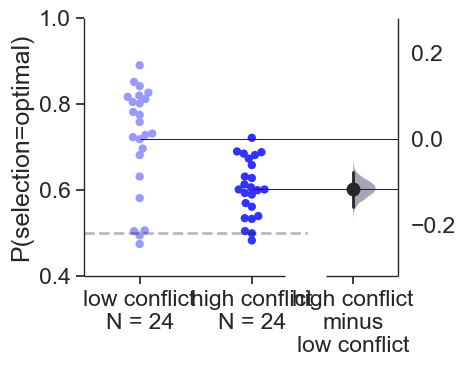

In [11]:
conf_acc_f = format_acc_plot(conf_acc_obj)
conf_acc_f.savefig(os.path.join(fig_path, 'loki0_conf_acc.png'), dpi=600, bbox_inches='tight', transparent=0)

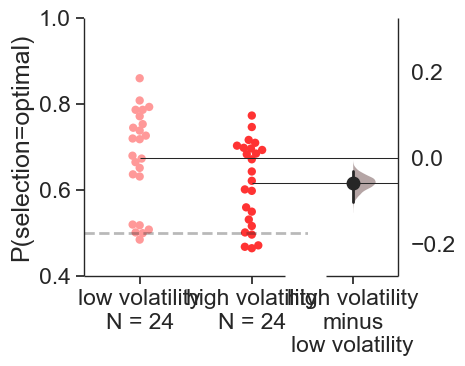

In [12]:
vol_acc_f = format_acc_plot(vol_acc_obj)
vol_acc_f.savefig(os.path.join(fig_path, 'loki0_vol_acc.png'),dpi=600, bbox_inches='tight', transparent=0)

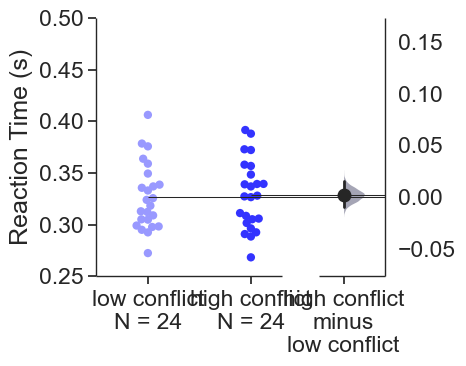

In [16]:
conf_rt_f = format_rt_plot(conf_rt_obj)
conf_rt_f.savefig(os.path.join(fig_path, 'loki0_conf_rt.png'), dpi=600, bbox_inches='tight', transparent=0)

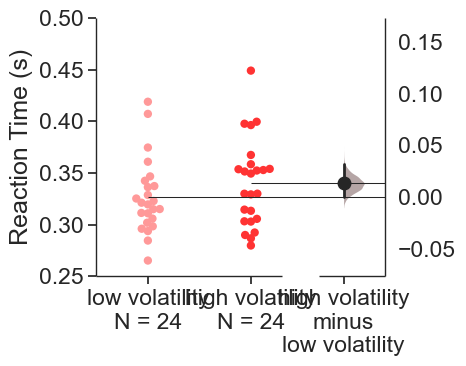

In [17]:
vol_rt_f = format_rt_plot(vol_rt_obj)
vol_rt_f.savefig(os.path.join(fig_path, 'loki0_vol_rt.png'),dpi=600, bbox_inches='tight', transparent=0)

In [23]:
conf_acc_obj.mean_diff # data objects have stats as attributes 

DABEST v0.3.0
             
Good evening!
The current time is Thu Oct 29 19:56:32 2020.

The paired mean difference between low conflict and high conflict is -0.115 [95%CI -0.158, -0.0775].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`

In [24]:
vol_acc_obj.mean_diff

DABEST v0.3.0
             
Good evening!
The current time is Thu Oct 29 19:56:36 2020.

The paired mean difference between low volatility and high volatility is -0.0573 [95%CI -0.102, -0.0301].
The p-value of the two-sided permutation t-test is 0.0012. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`

In [21]:
conf_rt_obj.mean_diff 

DABEST v0.3.0
             
Good evening!
The current time is Thu Oct 29 19:56:51 2020.

The paired mean difference between low conflict and high conflict is 0.00207 [95%CI -0.0101, 0.0153].
The p-value of the two-sided permutation t-test is 0.771. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`

In [22]:
vol_rt_obj.mean_diff 

DABEST v0.3.0
             
Good evening!
The current time is Thu Oct 29 19:56:54 2020.

The paired mean difference between low volatility and high volatility is 0.0133 [95%CI 0.000103, 0.0317].
The p-value of the two-sided permutation t-test is 0.113. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`